# Graph Analysis - Mathieu VANDECASTEELE

# Université de Rouen - M2 SID Janv. 2019

In [1]:
# Import utiles
from graph import *
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cbook
import warnings
from networkx.algorithms import approximation
warnings.filterwarnings("ignore")

**L'objectif de ce notebook est d'illustrer l'implémentation de MCS - Maximum Commun Subgraph en Python.**

## Démonstration

J'ai créé des fonctions dans le but de faire des graphes sans networkx mais à savoir que j'ai fais en sorte que ma classe Graph soit convertible en Graph networkx a tout instant !
Voici deux graphes, le but est de retourner les edges 2,4,6 et 8 qui forment un carré comme étant le maximum common subgraph des deux graphes.

In [2]:
g = Graph("undirected")
list_edges = [('a','b'),('b','c'),('c','e'),('e','d'),('b','d'),('d','g'),('g','f'),('a','f'),('d','c'),('e','b')]
g.add_edges_from_list(list_edges)
g2 = Graph("undirected")
list_edges2 = [('e','f'),('f','a'),('a','b'),('b','d'),('d','c'),('c','a'),('b','g'),('d','h'),('b','c'),('d','a')]
g2.add_edges_from_list(list_edges2)

In [3]:
g.build_graph_dictionary()
g2.build_graph_dictionary()

## Maximum Clique :

Je crée 2 graphes networkx

In [4]:
G = nx.Graph(g.graphdic)
G2 = nx.Graph(g2.graphdic)

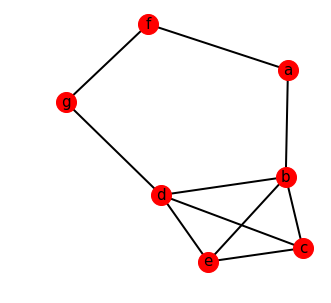

In [5]:
display_nxgraph(G)

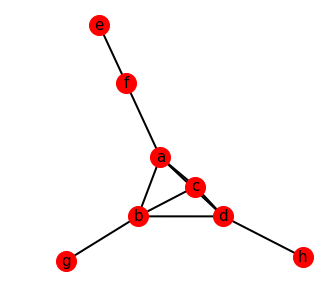

In [6]:
display_nxgraph(G2)

In [7]:
nodesInMaxClique = longest_list_in_a_list(list(nx.find_cliques(G)))

In [8]:
nodesInMaxClique2 = longest_list_in_a_list(list(nx.find_cliques(G2)))

In [9]:
cliquemax = extract_induced_subgraph(G,nodesInMaxClique)
cliquemax2 = extract_induced_subgraph(G2,nodesInMaxClique2)

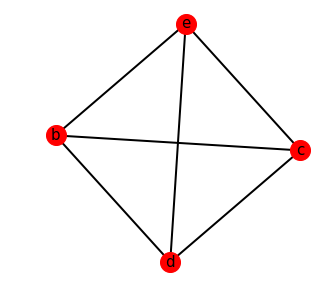

In [10]:
display_nxgraph(cliquemax)

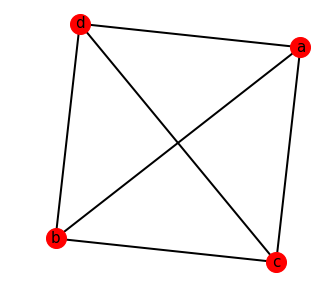

In [11]:
display_nxgraph(cliquemax2)

Je peux utiliser la GED pour calculer une distance entre deux graphs :

In [12]:
nx.graph_edit_distance(cliquemax,cliquemax2)

0.0

Nous avons une façon de déterminer une des cliques maximum d'un graph donc maintenant nous pouvons étendre notre problème au MCS :

# Maximum Common Induced Subgraph

**Définition de Wikipédia d'un Induced Subgraph :**

*Formally, let G = (V, E) be any graph, and let S ⊂ V be any subset of vertices of G. Then the induced subgraph G[S] is the graph whose vertex set is S and whose edge set consists of all of the edges in E that have both endpoints in S. The same definition works for undirected graphs, directed graphs, and even multigraphs.*

*The induced subgraph G[S] may also be called the subgraph induced in G by S, or (if context makes the choice of G unambiguous) the induced subgraph of S.*


Donc, après interprétation **il s'agit de graphes dont on a enlevé des vertex depuis un graphe d'origine et donc tous les edges reliés à ce dernier. On enlève pas de edges entre deux noeux non-retirés.**

## Première solution BruteForce

Maximum Common Induced Subgraph est NP-Hard. Probablement que cela va demander beaucoup de ressources donc nous aborderons des graphes avec maximum 100 vertex.
Le but est donc d'approximer une solution. Nous pouvons imaginer la recette suivante :

* Lister tous les sous-graphes possibles d'un Graph avec des déletions de vertex.
* Faire de même avec un second Graph.
* Comparer les deux listes de sous-graphes avec un calcul de similarité, on retourne tous les graphes identiques 2 à 2.
* On retourne une des solutions ayant le plus de vertex possible.

In [13]:
d = combinations_recursive(G)


In [14]:
extract_induced_subgraph(G,(d[0]))

In [15]:
s = extract_all_induced_subgraphs(G,d)

In [14]:
communs = mcs(G,G2)

Combinaisons en construction...
Terminé!
Extraction des Induced Subgraphs...
Terminé!
Distances...
Terminé!


In [20]:
communs[420:433]

[(<networkx.classes.graph.Graph at 0x11c9be9e8>,
  4),
 (<networkx.classes.graph.Graph at 0x11c9beb00>,
  4),
 (<networkx.classes.graph.Graph at 0x11c9beb00>,
  4),
 (<networkx.classes.graph.Graph at 0x11c9beb00>,
  4),
 (<networkx.classes.graph.Graph at 0x11c9beb00>,
  4),
 (<networkx.classes.graph.Graph at 0x11c9beb00>,
  4),
 (<networkx.classes.graph.Graph at 0x11c9beb38>,
  5),
 (<networkx.classes.graph.Graph at 0x11c9beb70>,
  5),
 (<networkx.classes.graph.Graph at 0x11c9bebe0>,
  5),
 (<networkx.classes.graph.Graph at 0x11c9bed68>,
  5),
 (<networkx.classes.graph.Graph at 0x11c9bed68>,
  5),
 (<networkx.classes.graph.Graph at 0x11c9bed30>,
  5),
 (<networkx.classes.graph.Graph at 0x11c9bed30>,
  5)]

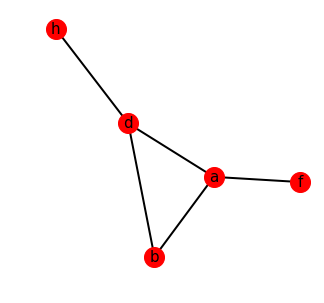

In [26]:
display_nxgraph(communs[428][1])

In [2]:
M = nx.dense_gnm_random_graph(10,25)
M2 = nx.dense_gnm_random_graph(9,25)

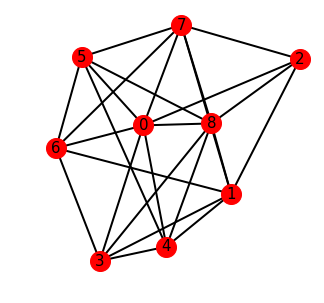

In [3]:
display_nxgraph(M2)

In [23]:
nodesInMaxClique = len(longest_list_in_a_list(list(nx.find_cliques(M))))
nodesInMaxClique2 = len(longest_list_in_a_list(list(nx.find_cliques(M2))))
print(min(nodesInMaxClique,nodesInMaxClique2))

4


In [ ]:
communs = mcs(M,M2,4)

Combinaisons en construction...
Nombre de combinaisons Graph 1 :
848
Nombre de combinaisons Graph 2 :
382
Terminé!
Extraction des Induced Subgraphs...
Terminé!
Distances...


In [5]:
len(communs)

29

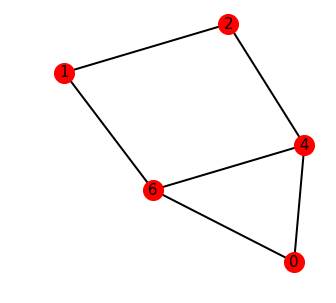

In [17]:
display_nxgraph(communs[0][0])

In [20]:
nodesInMaxClique = longest_list_in_a_list(list(nx.find_cliques(M2)))

In [19]:
nodesInMaxClique

[0, 8, 2, 7]